# Euclidean Alignment + Weighted TL

## Load dataset

In [1]:
import sys

In [2]:
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\csp')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import moabb.datasets
import moabb.paradigms


from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

In [4]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [5]:
# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    data_path = '../../datasets/BCICIV2a/A{:02d}T.npz'.format(subj)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['raw_EEG'] = deepcopy(ori_data[subj]['s'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['raw_EEG'] = np.delete(mod_data[subj]['raw_EEG'], np.s_[22:], 1)

## Preprocessing

### Apply Bandpass Filter

In [6]:
from scipy.signal import firwin, freqs, lfilter

In [7]:
# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [8]:
## PREPROCESSING ##

# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

# Key to store result
EEG_filtered = 'EEG_filtered'

for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['raw_EEG']
    
    mod_data[subj][EEG_filtered] = apply_bandpass(temp_raw_EEG, b)

### Fetch Left and Right Class

In [9]:
mod_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
mod_data[1].keys()

dict_keys(['raw_EEG', 'EEG_filtered'])

In [11]:
## Only fetch left and right class
mod_data = fetch_left_right_EEG(mod_data, ori_data=ori_data)
    
# Checking current size of EEG left and right data
print('\t\tLeft \t\t Right')

for subj in mod_data.keys():
    
    temp = mod_data[subj]
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['EEG_left'].shape, temp['EEG_right'].shape)) 

Processing for  1
Processing for  2
Processing for  3
Processing for  4
Processing for  5
Processing for  6
Processing for  7
Processing for  8
Processing for  9
		Left 		 Right
subject01:	(72, 22, 750)	(72, 22, 750)
subject02:	(72, 22, 750)	(72, 22, 750)
subject03:	(72, 22, 750)	(72, 22, 750)
subject04:	(72, 22, 750)	(72, 22, 750)
subject05:	(72, 22, 750)	(72, 22, 750)
subject06:	(72, 22, 750)	(72, 22, 750)
subject07:	(72, 22, 750)	(72, 22, 750)
subject08:	(72, 22, 750)	(72, 22, 750)
subject09:	(72, 22, 750)	(72, 22, 750)


## Apply Data Alignment on raw EEG

In [12]:
# Import necessary library
from scipy.linalg import sqrtm, inv 

def apply_EA(data, key_list):
    '''
    Apply Euclidean aligment on array-like objects for 1 subject
    
    PARAMETER:
    data:
    dictionary containing left and right EEG data of each subject
    
    key_list:
    keys inside dict in which data that is about to be aligned are stored
    
    OUTPUT:
    dictionary data with aligned version of key_list
    '''
    
    # Processing each value in key_list
    for key in key_list:
        all_trials = data[key]

        # Calculate reference matrix
        R = 0

        # Iterate over all trials
        for trial in all_trials:
            cov = trial@trial.T
            R += cov

        # Average over all trials
        R = R/all_trials.shape[0]

        # Compute R^(-0.5)
        R_inv = sqrtm(inv(R))

        # Perform alignment on each trial
        X_hat = []
        for trial in all_trials:
            X_hat.append(R_inv@trial)

        # Store as a new key in data dictionary
        # alg stands for aligned
        new_key = key + str('_alg')
        print('name of new key ', new_key)

        data[new_key] = np.array(X_hat)

In [13]:
# Iterate over all subjects to compute the aligned EEG trials
# Define keys to be processed
process_key = ['EEG_left', 'EEG_right']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  2
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  3
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  4
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  5
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  6
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  7
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  8
name of new key  EEG_left_alg
name of new key  EEG_right_alg

Processing subject  9
name of new key  EEG_left_alg
name of new key  EEG_right_alg



In [14]:
left_alg = mod_data[3]['EEG_left_alg']

In [15]:
left_alg.shape

(72, 22, 750)

In [16]:
summ = 0

In [17]:
for tr in left_alg:
    summ += tr@tr.T
    
I = summ/left_alg.shape[0]
I = pd.DataFrame(np.round(I, 2))

In [18]:
I

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
3,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
4,-0.0,-0.0,-0.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
5,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0
6,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
7,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0
8,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,...,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0
9,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,...,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0


In [20]:
# Sanity check
for subj in mod_data.keys():
    summ = 0
    
    left_alg = mod_data[subj]['EEG_left_alg']
    right_alg = mod_data[subj]['EEG_right_alg']
    
    for tr in left_alg:
        summ += tr@tr.T
    
    I = summ/left_alg.shape[0]
    I = pd.DataFrame(np.round(I, 2))
    
    # Sum up all matrix elements should equal to number of eeg channels, i.e. 22
    assert (I.sum().sum() == 22)
    print('Subject {} OK!'.format(subj))

Subject 1 OK!
Subject 2 OK!
Subject 3 OK!
Subject 4 OK!
Subject 5 OK!
Subject 6 OK!
Subject 7 OK!
Subject 8 OK!
Subject 9 OK!


## Visualize raw data with and without EA

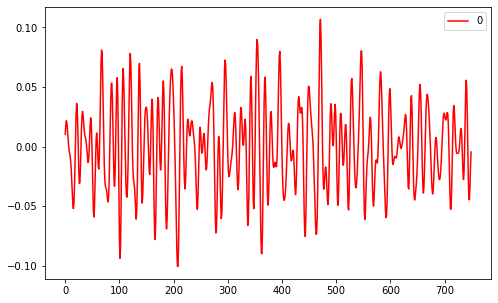

In [126]:
# let's try for one subject
fig, ax = plt.subplots(1, 1,  figsize=(8, 5))
n_alg = pd.DataFrame(mod_data[1]['EEG_left'][10][5])
alg = pd.DataFrame(mod_data[1]['EEG_left_alg'][10][5])

# n_alg.plot(ax=ax, color='k')
alg.plot(ax=ax, color='red')
plt.show()

In [124]:
def visualize_raw_and_aligned(data_dict, no_subj=1, no_trial=0, fs=250):
    '''
    Will plot the visualization of dictionary, left and right hand class
    
    Parameter:
    data_dict = data containing data of each subject
    '''
    left = data_dict[no_subj]['EEG_left'][no_trial]
    right = data_dict[no_subj]['EEG_right'][no_trial]
    left_alg = data_dict[no_subj]['EEG_left_alg'][no_trial]
    right_alg = data_dict[no_subj]['EEG_right_alg'][no_trial]
    
    # Time
    time = np.arange(aa[trial].size)/fs
    
    # Number of electrodes
    n_el = data.shape[0]
    
    # Plot each raw EEG and aligned raw EEG
    fig, axes = plt.subplots(n_el, 2, figsize=(10, 15), sharex=True)
    
    # Title to each column
    axes[0, 0].set_title('Left')
    axes[0, 1].set_title('Right')

    # Plot each eeg raw and aligned 
    for i, ax in enumerate(axes):
        ax[0].plot(time, left[i], color='k', label='el ' + str(i))
        ax[0].plot(time, left_alg[i], color='r', label='el ' + str(i))
        ax[0].legend(loc=1)
        
        ax[1].plot(time, right[i], color='k', label='el ' + str(i))
        ax[1].plot(time, right_alg[i], color='r', label='el ' + str(i))
        ax[1].legend(loc=1)
    plt.show()

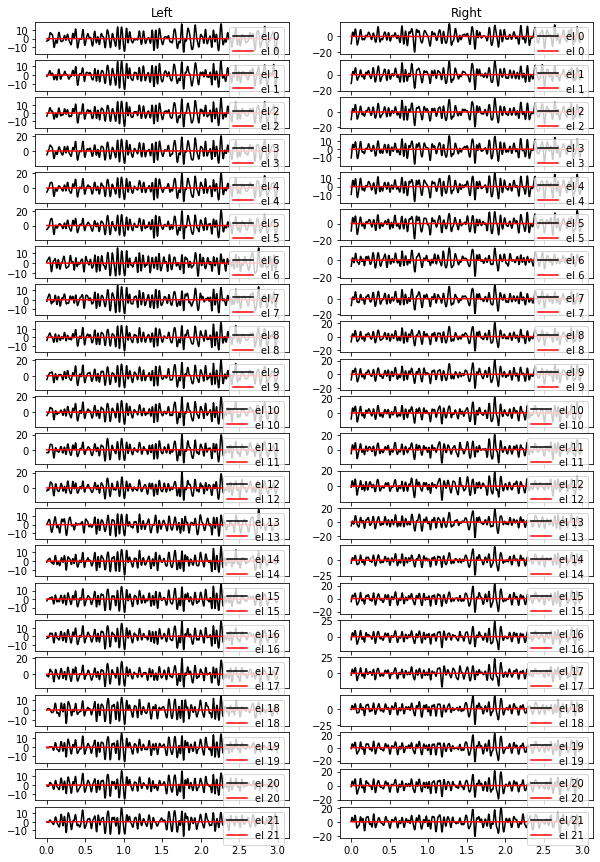

In [125]:
visualize_raw_and_aligned(mod_data, no_subj=8, no_trial=0, fs=250)

In [6]:
## Split to train and test data
for subj in mod_data.keys():
    print('Processing split for', subj)
    
    mod_data[subj]['EEG_left_train'], mod_data[subj]['EEG_left_test'] = split_EEG_one_class(mod_data[subj]['EEG_left'], 0.8)
    mod_data[subj]['EEG_right_train'], mod_data[subj]['EEG_right_test'] = split_EEG_one_class(mod_data[subj]['EEG_right'], 0.8)     
 

Processing split for subject01
Processing split for subject02
Processing split for subject03
Processing split for subject04
Processing split for subject05
Processing split for subject06
Processing split for subject07
Processing split for subject08
Processing split for subject09


In [7]:
# Checking size of EEG left and right data training and test data
print('\t\tLeft \t\t Right')
print('TRAINING')
for i in range(1, ns):
    
    subj = subject_counter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, temp['EEG_left_train'].shape, temp['EEG_right_train'].shape))

print('TEST')
for i in range(1, ns):
    
    subj = subject_counter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, temp['EEG_left_test'].shape, temp['EEG_right_test'].shape))

		Left 		 Right
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22, 750)
subject05:	(58, 22, 750)	(58, 22, 750)
subject06:	(58, 22, 750)	(58, 22, 750)
subject07:	(58, 22, 750)	(58, 22, 750)
subject08:	(58, 22, 750)	(58, 22, 750)
subject09:	(58, 22, 750)	(58, 22, 750)
TEST
subject01:	(14, 22, 750)	(14, 22, 750)
subject02:	(14, 22, 750)	(14, 22, 750)
subject03:	(14, 22, 750)	(14, 22, 750)
subject04:	(14, 22, 750)	(14, 22, 750)
subject05:	(14, 22, 750)	(14, 22, 750)
subject06:	(14, 22, 750)	(14, 22, 750)
subject07:	(14, 22, 750)	(14, 22, 750)
subject08:	(14, 22, 750)	(14, 22, 750)
subject09:	(14, 22, 750)	(14, 22, 750)


## CSP

In [8]:
csp = CSP()

for i in range(1, ns):
    subj = subject_counter(i)
    print('Computing cov for ', subj)
    print('---------------------------')
    
    mod_data[subj]['CSP'] = {}
    
    # Covariance
    print('Computing covariance of each class and composite covariance')
    mod_data[subj]['CSP']['cov_left'] = csp.compute_cov(mod_data[subj]['EEG_left_train'])
    mod_data[subj]['CSP']['cov_right'] = csp.compute_cov(mod_data[subj]['EEG_right_train'])
    mod_data[subj]['CSP']['cov_comp']  = mod_data[subj]['CSP']['cov_left'] + mod_data[subj]['CSP']['cov_right']
    
    # Whitening matrix
    print('Computing eigenval, eigenvec, and whitening matrix of composite covariance ')
    mod_data[subj]['CSP']['whitening'] = {}
    
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening = mod_data[subj]['CSP']['whitening']
    temp_cov = mod_data[subj]['CSP']['cov_comp']
    
    temp_whitening['eigval'], temp_whitening['eigvec'] = csp.decompose_cov(temp_cov)

    # White matrix
    temp_whitening['P'] = csp.white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])
    
    # Common eigenvec from Sl and Sr
    print('Generating common eigenvector from each class')
    mod_data[subj]['CSP']['S_left'] = {}
    mod_data[subj]['CSP']['S_right'] = {}  
    
    # Where to access data
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    Cl = mod_data[subj]['CSP']['cov_left']
    Cr = mod_data[subj]['CSP']['cov_right']
    
    # Where to store result
    temp_Sl = mod_data[subj]['CSP']['S_left']
    temp_Sr = mod_data[subj]['CSP']['S_right']

    # LEFT
    Sl = csp.compute_S(Cl, temp_P)
    temp_Sl['eigvec'], temp_Sl['eigval'] = csp.decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = csp.compute_S(Cr, temp_P)
    temp_Sr['eigvec'], temp_Sr['eigval'] = csp.decompose_S(Sr, 'ascending')   
    
    # Spatial filter
    print('Spatial filter for ',subj)
    temp_eigvec = mod_data[subj]['CSP']['S_left']['eigvec']
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    
    mod_data[subj]['CSP']['W'] = csp.spatial_filter(temp_eigvec, temp_P)
    
    print(' ')

Computing cov for  subject01
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  subject01
 
Computing cov for  subject02
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  subject02
 
Computing cov for  subject03
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  subject03
 
Computing cov for  subject04
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covari

## Train Feature

In [9]:
# Select number of filter
m = 2

# Seed to fix randomization
np.random.seed(42)

# Create new keys for trainning and test feature vector
for i in range(1, ns):
    subj = subject_counter(i)
    
    print('Generating training vector for ', subj)
    
    mod_data[subj]['train']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['EEG_left_train']
    temp_EEG_right = mod_data[subj]['EEG_right_train']
    
    # LEFT
    mod_data[subj]['train']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['train']['feat_left'] = feat_vector(mod_data[subj]['train']['Z_left'])
    left_label = true_label(mod_data[subj]['train']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['train']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['train']['feat_right'] = feat_vector(mod_data[subj]['train']['Z_right'])     
    right_label = true_label(mod_data[subj]['train']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['train']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['train']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['train']['feat_train'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['train']['feat_train'])
    
    print('Training dataset shape {}\n'.format(mod_data[subj]['train']['feat_train'].shape))

Generating training vector for  subject01
Training dataset shape (116, 5)

Generating training vector for  subject02
Training dataset shape (116, 5)

Generating training vector for  subject03
Training dataset shape (116, 5)

Generating training vector for  subject04
Training dataset shape (116, 5)

Generating training vector for  subject05
Training dataset shape (116, 5)

Generating training vector for  subject06
Training dataset shape (116, 5)

Generating training vector for  subject07
Training dataset shape (116, 5)

Generating training vector for  subject08
Training dataset shape (116, 5)

Generating training vector for  subject09
Training dataset shape (116, 5)



In [10]:
mod_data['subject01']['train']['feat_train'][:5]

array([[-0.80850967, -0.6600156 , -0.48623359, -0.52374037,  1.        ],
       [-0.40809937, -0.50156184, -0.85628869, -0.80985649,  0.        ],
       [-0.45061195, -0.53515375, -0.78251033, -0.72343572,  0.        ],
       [-0.62933009, -0.5755371 , -0.46896779, -0.79636582,  0.        ],
       [-0.7143548 , -0.53946605, -0.52948956, -0.65221154,  0.        ]])

## Test Feature

In [11]:
# Create new keys for test feature vector
np.random.seed(42)

for i in range(1, ns):
    subj = subject_counter(i)
    
    print('Generating test vector for ', subj)
    
    mod_data[subj]['test']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['EEG_left_test']
    temp_EEG_right = mod_data[subj]['EEG_right_test']
      
    # LEFT
    mod_data[subj]['test']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['test']['feat_left'] = feat_vector(mod_data[subj]['test']['Z_left'])
    left_label = true_label(mod_data[subj]['test']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['test']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['test']['feat_right'] = feat_vector(mod_data[subj]['test']['Z_right'])     
    right_label = true_label(mod_data[subj]['test']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['test']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['test']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['test']['feat_test'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['test']['feat_test'])
    
    print('Test dataset shape {}\n'.format(mod_data[subj]['test']['feat_test'].shape))

Generating test vector for  subject01
Test dataset shape (28, 5)

Generating test vector for  subject02
Test dataset shape (28, 5)

Generating test vector for  subject03
Test dataset shape (28, 5)

Generating test vector for  subject04
Test dataset shape (28, 5)

Generating test vector for  subject05
Test dataset shape (28, 5)

Generating test vector for  subject06
Test dataset shape (28, 5)

Generating test vector for  subject07
Test dataset shape (28, 5)

Generating test vector for  subject08
Test dataset shape (28, 5)

Generating test vector for  subject09
Test dataset shape (28, 5)



## Preprocessing
First, grab only 'session_T' then divide eeg_data (X) into left and right hand   
In this early experiment subject 1 and 2 will be used as target while the rest as sources

In [47]:
ori_data[1]['X'].shape

(288, 22, 751)

In [50]:
# Only take data belonging to session_T, do this for all subjects
from copy import deepcopy
all_data = deepcopy(ori_data)

for subj in range(1, 10):
    idx = all_data[subj]['meta'][all_data[subj]['meta'].session == 'session_T'].index.values
    all_data[subj]['X'] = all_data[subj]['X'][idx]
    all_data[subj]['X'] = all_data[subj]['X'].reshape(all_data[subj]['X'].shape[0], all_data[subj]['X'].shape[1], all_data[subj]['X'].shape[2])
    all_data[subj]['y'] = all_data[subj]['y'][idx]
    
    # Divide them into left and right hand
    all_data[subj]['left_hand'] = all_data[subj]['X'][all_data[subj]['y'] == 'left_hand']
    all_data[subj]['right_hand'] = all_data[subj]['X'][all_data[subj]['y'] == 'right_hand']    

In [51]:
all_data[1]['X'].shape

(144, 22, 751)

In [117]:
all_data[1]['left_hand'][0][0][:50]

array([ -9.14191696, -11.40696936, -11.21258134,  -8.68376597,
        -4.59912832,  -0.07569719,   3.82230888,   6.37972667,
         7.34021711,   6.84364185,   5.27707906,   3.13170091,
         0.90441751,  -0.97811483,  -2.24226967,  -2.83512959,
        -2.91667921,  -2.75111618,  -2.55369506,  -2.39425553,
        -2.21951115,  -1.96513015,  -1.65853343,  -1.41987996,
        -1.3510833 ,  -1.3986444 ,  -1.30718873,  -0.72060542,
         0.61540869,   2.66583416,   5.04424169,   7.11533515,
         8.21400666,   7.88211124,   6.03172741,   2.98828778,
        -0.58888536,  -3.88415456,  -6.15702562,  -6.96137681,
        -6.27615009,  -4.49536536,  -2.28072811,  -0.33397538,
         0.82926733,   1.02836715,   0.4405955 ,  -0.5073915 ,
        -1.33304814,  -1.69128295])

In [113]:
fs = 250
mi_dur = 5

left_hand = []
for i in left_pos:
    print(i)
    left = X1['s'][i+int(fs*0.5): i + int(fs*3.5)]
    left_hand.append(left.T)
    
left_hand = np.array(left_hand)
#     right_hand = X1['s'][right_pos]

98242
100250
112163
114058
116030
124069
126135
130237
140283
154531
168776
186876
189204
191207
197085
201113
208998
214809
229142
239079
245162
251366
261676
283711
289960
297948
299998
313611
321841
333953
346094
348201
354427
364371
376373
380546
384877
386795
398764
402668
404563
430788
442929
447128
451262
455346
459281
469374
481712
489701
491618
505314
529584
537693
541871
546054
548097
550161
552181
572157
576544
600205
622505
626419
632502
636599
642889
646996
654876
663044
666878
671051


In [119]:
left_hand[0][0][:50]

array([-19.48242188, -16.65039062, -10.79101562, -15.0390625 ,
       -15.57617188, -16.25976562, -14.01367188, -16.89453125,
       -11.71875   , -11.08398438,  -3.36914062,  -5.90820312,
         0.43945312,   5.51757812,   5.2734375 ,   4.78515625,
         4.93164062,   9.27734375,   3.95507812,   4.44335938,
        -6.15234375,  -9.08203125,  -9.27734375, -13.96484375,
       -17.48046875, -18.75      , -24.95117188, -23.6328125 ,
       -24.95117188, -23.73046875, -22.265625  , -20.65429688,
       -22.11914062, -28.90625   , -26.41601562, -21.82617188,
       -28.27148438, -24.4140625 , -17.578125  , -17.52929688,
       -14.69726562,  -7.37304688,  -2.5390625 ,  -3.515625  ,
        -6.93359375,  -8.69140625,  -7.95898438,  -2.24609375,
        -6.00585938,  -4.93164062])

In [53]:
# Sanity check
# trial_no = 60
# assert np.all(all_data[1]['X'][trial_no][0].shape == ori_data[1]['X'][trial_no].shape)
# assert np.all(all_data[1]['X'][trial_no][0] == ori_data[1]['X'][trial_no])

In [18]:
# Currently label is still in string format change this to integer
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(all_data[1]['y'])

for i in all_data.keys():
    print('For subject:', i)
    print(all_data[i]['y'][:5])
    
    # Transform all label
    all_data[i]['y'] = enc.transform(all_data[i]['y'])
    
    print(all_data[i]['y'][:5])
    print('')

For subject: 1
['right_hand' 'left_hand' 'left_hand' 'right_hand' 'right_hand']
[1 0 0 1 1]

For subject: 2
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 3
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 4
['left_hand' 'left_hand' 'left_hand' 'right_hand' 'left_hand']
[0 0 0 1 0]

For subject: 5
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 6
['right_hand' 'right_hand' 'left_hand' 'right_hand' 'left_hand']
[1 1 0 1 0]

For subject: 7
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 8
['left_hand' 'right_hand' 'right_hand' 'left_hand' 'right_hand']
[0 1 1 0 1]

For subject: 9
['right_hand' 'right_hand' 'left_hand' 'right_hand' 'left_hand']
[1 1 0 1 0]



In [ ]:
#

In [46]:
ori_data[1]['meta'].session == 'session_T'

0      session_T
1      session_T
2      session_T
3      session_T
4      session_T
         ...    
283    session_E
284    session_E
285    session_E
286    session_E
287    session_E
Name: session, Length: 288, dtype: object

In [39]:
# Check with the original data npz
for i in range(1, 2):
    X = np.load('../../datasets/BCICIV2a/A{:02d}T.npz'.format(i))
    

In [42]:
X.files

['s', 'etyp', 'epos', 'edur', 'artifacts']